In [ ]:
# !pip install --upgrade scikit-learn
# ! pip install pydotplus


### 1. Imports des modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image  
import pydotplus

from statistics import mean 

from datetime import datetime
import ast

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

#CLASSIFIEURS
from sklearn import discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz


#CLUSTERING
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm_notebook as tqdm 


/home/agaltier/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### 2. Lecture des données

In [2]:
parse_dates = ['DATE']
glasses_df = pd.read_csv("./donnees/glasses.csv", parse_dates= parse_dates)
parse_dates = ['timestamp']
smartwatch_df = pd.read_csv("./donnees/smartwatch.csv", parse_dates= parse_dates)
smartphone_df = pd.read_csv("./donnees/smartphone.csv", parse_dates= parse_dates)
parse_dates = ['to', 'from']
report_df = pd.read_csv("./donnees/report.csv", parse_dates= parse_dates)

In [3]:
smartwatch_df.head()

,index,source,timestamp,values
0,164349,battery,2017-06-29 07:45:56.262,['98']
1,164350,accelerometer,2017-06-29 07:46:01.263,"['-0.3440857', '0.68330383', '9.967361']"
2,164351,gravity,2017-06-29 07:46:01.324,"['-0.34131828', '0.6573288', '9.778641']"
3,164352,linear_acceleration,2017-06-29 07:46:01.329,"['-0.018068999', '0.034808993', '-0.033065796']"
4,164353,gyroscope,2017-06-29 07:46:01.402,"['0.0041656494', '-0.0132751465', '0.006164551']"


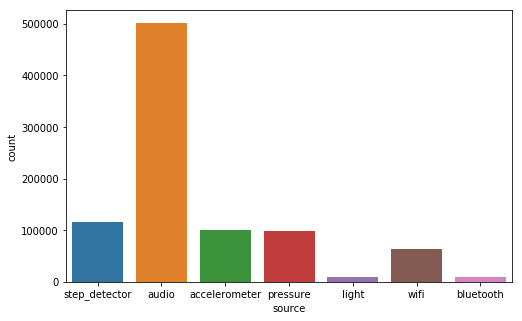

In [4]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="source", data=smartphone_df[smartphone_df.source.isin(['step_detector',
 'audio',
 'accelerometer',
 'pressure',
 'light',
 'wifi',
 'bluetooth'])])

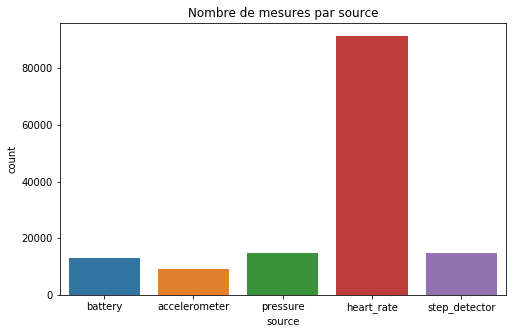

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.countplot(x="source", data=smartwatch_df[smartwatch_df.source.isin(['battery',
'accelerometer',
'pressure',
'heart_rate',
'step_detector'])]).set_title('Nombre de mesures par source')

### 3. Preparation des donnees Smartwatch

In [6]:
data = {}

data['heart_rate'] = [None] * len(smartwatch_df)

for index, row in tqdm(smartwatch_df.iterrows(), total=len(smartwatch_df)):
    
    
    values = [ float(x) for x in ast.literal_eval(row['values']) ]

    if row['source'] == 'heart_rate':
        data['heart_rate'][index] = values[0]


smartwatch_df["heart_rate"] = data['heart_rate']

resampling_functions = {
    'heart_rate': np.mean,
}

smartwatch_df = smartwatch_df[ 
                                smartwatch_df['heart_rate'].notnull()  
    
                             ]

smartwatch_df = smartwatch_df.set_index('timestamp')
smartwatch_df = smartwatch_df['heart_rate']
smartwatch_df = smartwatch_df.resample('min').agg(resampling_functions)
smartwatch_df = smartwatch_df.dropna()
smartwatch_df.head()

HBox(children=(IntProgress(value=0, max=200471), HTML(value='')))

            timestamp          
heart_rate  2017-06-29 07:46:00    129.568182
            2017-06-29 07:47:00    111.095238
            2017-06-29 07:48:00     75.076923
            2017-06-29 07:49:00     68.076923
            2017-06-29 07:50:00     64.666667
Name: heart_rate, dtype: float64

In [7]:
data = {}

data['audio'] = [None] * len(smartphone_df)
data['steps'] = [None] * len(smartphone_df)
data['wifi'] = [None] * len(smartphone_df)
data['accelerometer'] = [None] * len(smartphone_df)


for index, row in tqdm(smartphone_df.iterrows(), total=len(smartphone_df)):
    
    if row['source'] != 'activity':
        values = [ float(x) for x in ast.literal_eval(row['values']) ]

        if row['source'] == 'audio':
            data['audio'][index] = mean(values)

        if row['source'] == 'step_detector':
            data['steps'][index] = values[0]

        if row['source'] == 'accelerometer':
            data['accelerometer'][index] = (sum([x**2 for x in values]))**0.5

        if row['source'] == 'wifi':
            data['wifi'][index] = len(values)

smartphone_df["audio"] = data['audio']
smartphone_df["wifi"] = data['wifi']
smartphone_df["steps"] = data['steps']
smartphone_df["accelerometer"] = data['accelerometer']


resampling_functions = {
    'audio': np.mean,
    'wifi': np.mean,
    'steps': np.sum,
    'accelerometer': np.mean
}

smartphone_df = smartphone_df[ 
                    smartphone_df['audio'].notnull() | 
                    smartphone_df['wifi'].notnull() | 
                    smartphone_df['steps'].notnull() |
                    smartphone_df['accelerometer'].notnull()
                             ]

smartphone_df = smartphone_df.set_index('timestamp')
smartphone_df = smartphone_df[['audio','wifi', 'steps', 'accelerometer']]
smartphone_df = smartphone_df.resample('min').agg(resampling_functions)
smartphone_df['steps'].fillna(0.0, inplace=True)
smartphone_df = smartphone_df.dropna()
smartphone_df.head()

HBox(children=(IntProgress(value=0, max=1528218), HTML(value='')))

,audio,wifi,steps,accelerometer
timestamp,,,,
2017-06-29 07:45:00,7843.096284,3.250000,6.0,9.648525
2017-06-29 07:46:00,9393.916199,2.833333,0.0,9.535087
2017-06-29 07:47:00,11556.857947,3.666667,23.0,9.262378
2017-06-29 07:48:00,10962.091658,3.500000,11.0,9.459278
2017-06-29 07:49:00,9936.258735,4.500000,5.0,9.496311


### 3. Jointure des datasets

In [36]:
df = smartphone_df.join(smartwatch_df, lsuffix='_sp', rsuffix='_sw')
df = df.reset_index(level=0)
df = df.drop('level_0', axis = 1)
df.head()

,audio,wifi,steps,accelerometer,heart_rate
timestamp,,,,,
2017-06-29 07:46:00,9393.916199,2.833333,0.0,9.535087,129.568182
2017-06-29 07:47:00,11556.857947,3.666667,23.0,9.262378,111.095238
2017-06-29 07:48:00,10962.091658,3.500000,11.0,9.459278,75.076923
2017-06-29 07:49:00,9936.258735,4.500000,5.0,9.496311,68.076923
2017-06-29 07:50:00,9793.723331,3.833333,2.0,9.357087,64.666667


In [37]:
df.describe()

,audio,wifi,steps,accelerometer,heart_rate
count,2941.000000,2941.000000,2941.000000,2941.000000,2941.000000
mean,11054.503442,9.169480,20.901054,10.211509,70.346160
std,1879.503866,15.076354,36.824673,1.449701,13.578696
min,1827.792060,0.000000,0.000000,6.795452,47.666667
25%,9769.336971,3.000000,0.000000,9.674455,62.285714
50%,10602.857125,4.000000,1.000000,9.903864,67.532738
75%,11716.650800,5.833333,26.000000,10.099466,74.500000
max,18595.348573,123.250000,170.000000,29.229536,166.800000


In [38]:
report_df.head()

,index,activity_type,duration,from,to,comment
0,0,Video games,01:43,2017-07-01 21:34:00,2017-07-01 23:17:00,NaN
1,1,In computer,00:03,2017-07-01 21:29:00,2017-07-01 21:32:00,NaN
2,2,At home,13:35,2017-07-01 21:13:00,2017-07-02 10:49:00,NaN
3,3,In computer,00:05,2017-07-01 21:08:00,2017-07-01 21:13:00,NaN
4,4,Eat,00:18,2017-07-01 20:49:00,2017-07-01 21:07:00,NaN


In [39]:
data = {}
data['activity_index'] = [None] * len(df)
data['activity_type'] = [None] * len(df)

i=0
for index, row in tqdm(df.iterrows(), total=len(df)):
    for report_index, report_row in report_df.iterrows():
        if (index >= report_row['from']) & (index < report_row['to']):
            data['activity_type'][i] = report_row['activity_type']
    i=i+1

df["activity_type"] = data['activity_type']
df = df.dropna()

df['hour'] = pd.Series(list(df.index)).dt.hour.tolist()

# df['hour'] = df.index.hour
# add_var = pd.get_dummies(df['hour'], prefix='hour', drop_first=True)
# df = df.join(add_var)
# df = df.drop(columns=['hour'])

df.head()

HBox(children=(IntProgress(value=0, max=2941), HTML(value='')))

,audio,wifi,steps,accelerometer,heart_rate,activity_type,hour
timestamp,,,,,,,
2017-06-29 09:57:00,12883.949970,47.125000,91.0,12.654205,76.083333,Eat,9
2017-06-29 09:58:00,12258.789152,56.750000,53.0,10.117409,83.500000,Eat,9
2017-06-29 10:01:00,12155.157763,60.000000,50.0,9.982670,58.784810,Eat,10
2017-06-29 10:02:00,13177.428694,65.666667,107.0,10.720635,71.727273,Eat,10
2017-06-29 10:03:00,12905.517089,65.500000,91.0,10.717644,91.750000,Eat,10


In [40]:
df['activity_type'].unique()

array(['Eat', 'In vehicle', 'Walk', 'In bus', 'At home', 'Walking&party',
       'Train', 'Work', 'Shop', 'Sleep', 'In computer', 'Picnic ',
       'Meeting', 'Cooking', 'Movie', 'Video games', 'Pause',
       'Shopping& wearing'], dtype=object)

### 3. Exploration des donnees

In [41]:
df.describe()

,audio,wifi,steps,accelerometer,heart_rate,hour
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000
mean,11186.460741,9.215078,20.471063,10.269537,70.488197,15.062584
std,2008.689603,15.836743,37.460626,1.501122,15.445777,2.418946
min,1827.792060,0.000000,0.000000,8.523582,49.250000,9.000000
25%,9770.442541,3.000000,0.000000,9.700441,62.193382,13.000000
50%,10655.715156,4.000000,1.000000,9.968008,67.383484,15.000000
75%,11968.765699,5.833333,25.000000,10.132207,73.909091,17.000000
max,18595.348573,123.250000,170.000000,25.912000,166.800000,21.000000


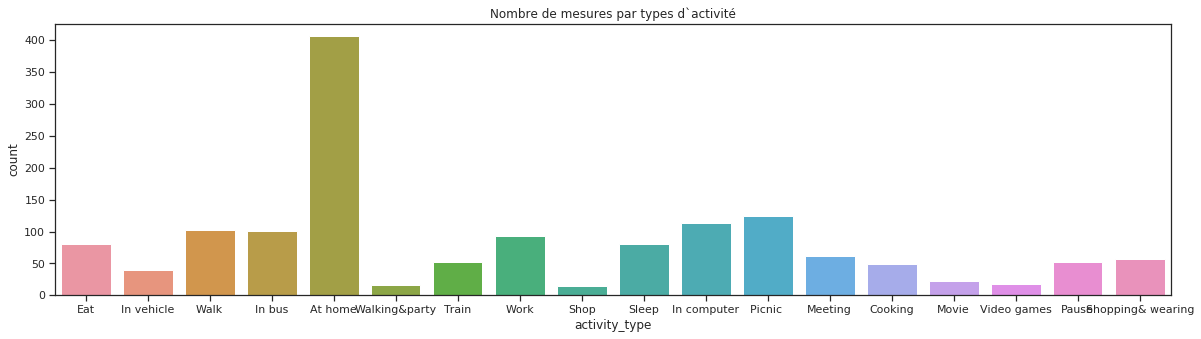

In [42]:
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

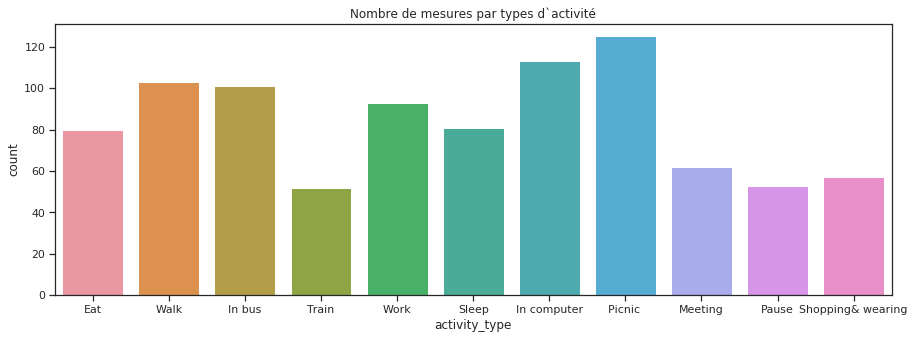

In [43]:
df = df.drop(df.index[df['activity_type'] == 'At home'], axis = 0)
df = df.drop(df.index[df['activity_type'] == 'Walking&party'], axis = 0)
# df = df.drop(df.index[df['activity_type'] == 'In computer'], axis = 0)
# df = df.drop(df.index[df['activity_type'] == 'Shopping& wearing'], axis = 0)
# df = df.drop(df.index[df['activity_type'] == 'Eat'], axis = 0)
for activity_type in df['activity_type'].unique():
    if len(df[df['activity_type'] == activity_type])<=50:
        df = df.drop(df.index[df['activity_type'] == activity_type], axis = 0)

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x="activity_type", data=df).set_title('Nombre de mesures par types d`activité')

In [44]:
len(df['activity_type'].unique())

11

In [45]:
v = []
for activity_type in df.activity_type.unique():
    v.append(len(df[df['activity_type']==activity_type]))
v

[80, 103, 101, 52, 93, 81, 113, 125, 62, 53, 57]

In [46]:
pd.Series(v).describe()

count     11.000000
mean      83.636364
std       25.445128
min       52.000000
25%       59.500000
50%       81.000000
75%      102.000000
max      125.000000
dtype: float64

In [47]:
variables = [
    'audio',
    'wifi',
    'steps',
    'accelerometer',
    'heart_rate',
    'hour',
]

hours = [
    'hour_10',
    'hour_11',
    'hour_12',
    'hour_13',
    'hour_14',
    'hour_15',
    'hour_16',
    'hour_17',
    'hour_18',
    'hour_19',
    'hour_21'
]


# Centrage reduction des donnees quantitatives
normal_scaler = preprocessing.StandardScaler()
normal_scaler_fit = normal_scaler.fit(df[variables])
normal = normal_scaler_fit.transform(df[variables])

# X et Y: entrees et sorties du modele

X = pd.DataFrame(normal, columns=variables)


y = df['activity_type']

df_normal = pd.DataFrame(normal, columns=variables)
df_normal['activity_type'] = df['activity_type'].tolist()

# X = X.join(pd.DataFrame(np.array(df[hours]), columns = hours))

In [48]:
df_normal.head()

,audio,wifi,steps,accelerometer,heart_rate,hour,activity_type
0,0.915755,2.011075,2.273952,2.852959,0.734403,-2.929641,Eat
1,0.578892,2.543842,1.095375,0.017336,1.519857,-2.929641,Eat
2,0.523051,2.723737,1.002330,-0.133275,-1.097580,-2.433823,Eat
3,1.073893,3.037401,2.770195,0.691620,0.273079,-2.433823,Eat
4,0.927376,3.028176,2.273952,0.688277,2.393565,-2.433823,Eat


In [49]:
df[variables].describe()

,audio,wifi,steps,accelerometer,heart_rate,hour
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,11184.463032,10.792783,17.682609,10.101900,69.148725,14.908696
std,1856.841580,18.075892,32.259815,0.895103,9.447652,2.017964
min,1827.792060,0.000000,0.000000,8.523582,49.250000,9.000000
25%,9826.250588,3.166667,0.000000,9.691595,62.492647,14.000000
50%,10634.524182,4.000000,0.000000,9.948580,67.773504,15.000000
75%,12090.763921,8.000000,22.000000,10.131942,73.910985,16.000000
max,18595.348573,123.250000,147.000000,18.212669,111.000000,21.000000


In [50]:
df_normal.describe()

,audio,wifi,steps,accelerometer,heart_rate,hour
count,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02,9.200000e+02
mean,-4.923598e-17,1.740154e-16,1.795665e-16,-1.187456e-16,-3.078455e-16,9.267949e-17
std,1.000544e+00,1.000544e+00,1.000544e+00,1.000544e+00,1.000544e+00,1.000544e+00
min,-5.041766e+00,-5.974064e-01,-5.484293e-01,-1.764239e+00,-2.107354e+00,-2.929641e+00
25%,-7.318617e-01,-4.221238e-01,-5.484293e-01,-4.586383e-01,-7.049051e-01,-4.505482e-01
50%,-2.963301e-01,-3.759968e-01,-5.484293e-01,-1.713810e-01,-1.456413e-01,4.527040e-02
75%,4.883528e-01,-1.545872e-01,1.339047e-01,3.358006e-02,5.043423e-01,5.410890e-01
max,3.993295e+00,6.224776e+00,4.010802e+00,9.066192e+00,4.432217e+00,3.020182e+00


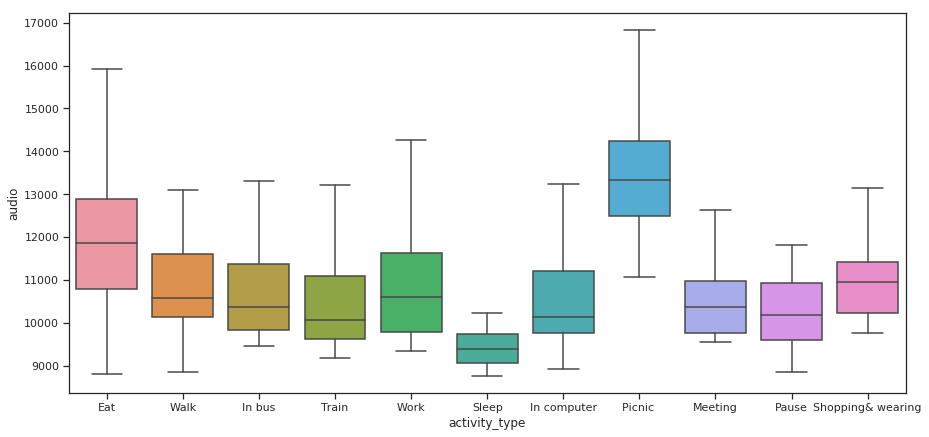

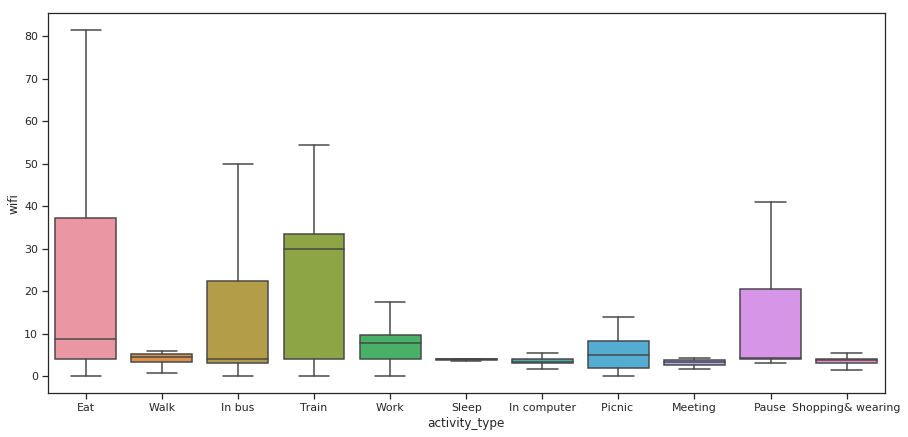

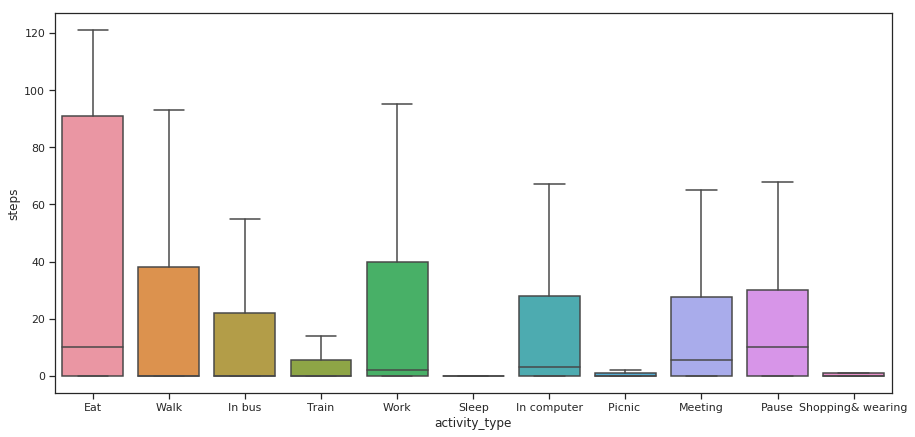

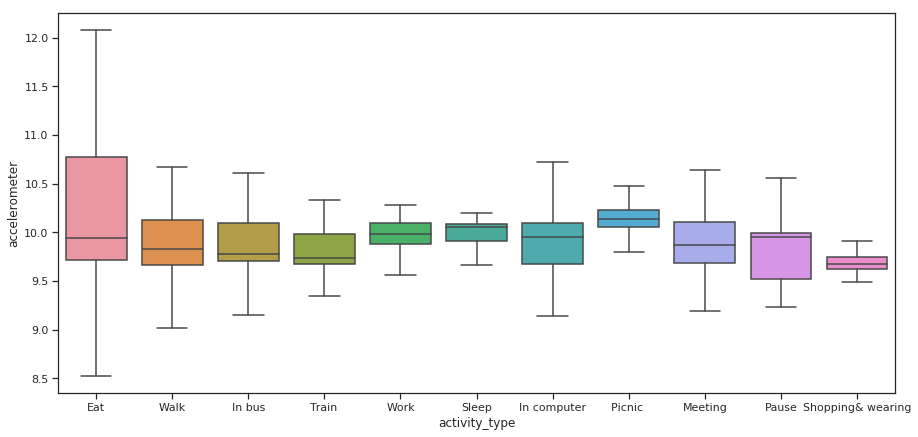

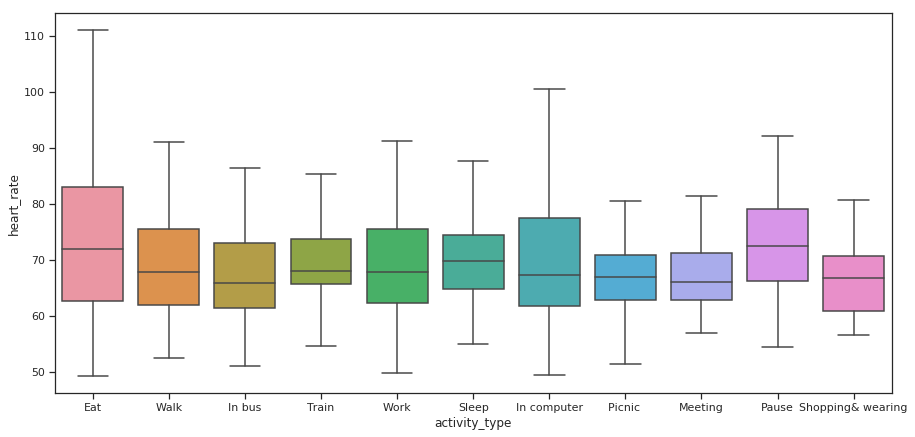

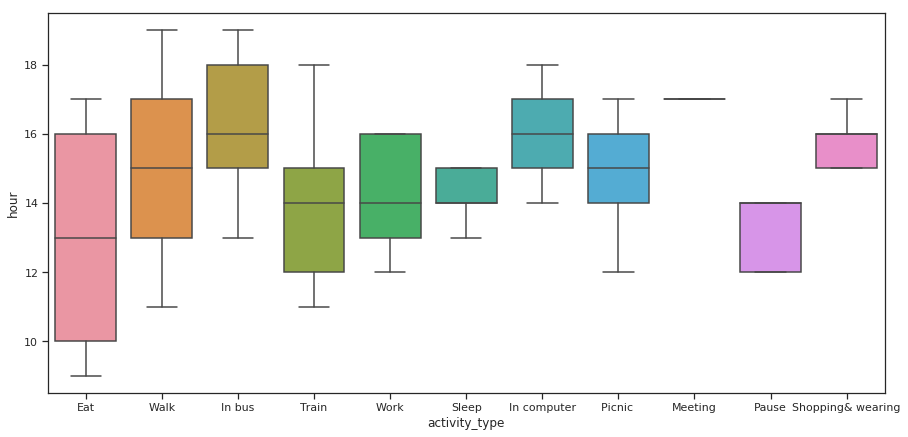

In [51]:
for variable in [
                    'audio',
                    'wifi',
                    'steps',
                    'accelerometer',
                    'heart_rate',
                    'hour'
                ]:
    
    fig, ax = plt.subplots(figsize=(15,7))
    sns.set(style="ticks", color_codes=True)
    sns.boxplot(x="activity_type", y=variable, data=df, showfliers = False)

/home/agaltier/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


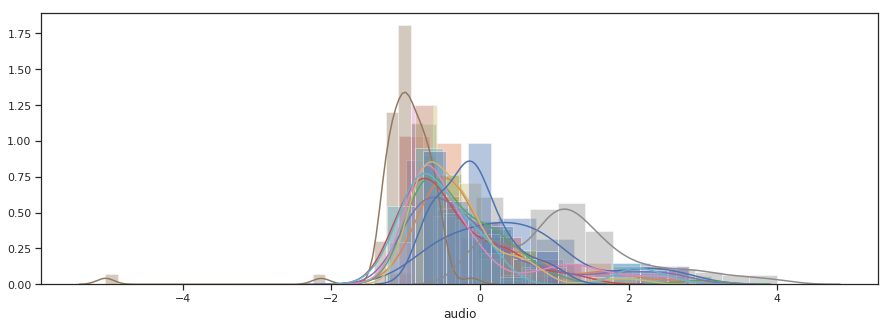

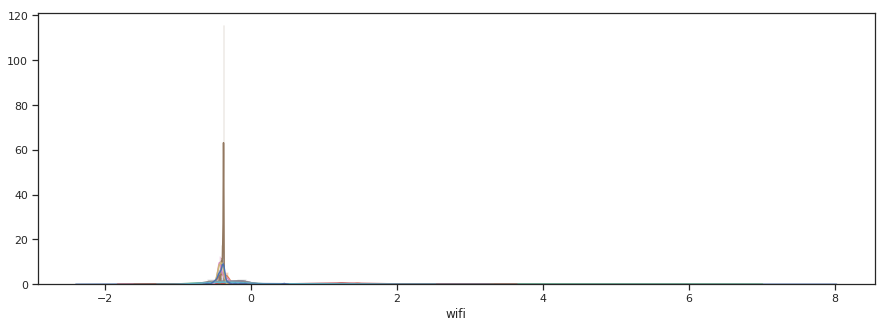

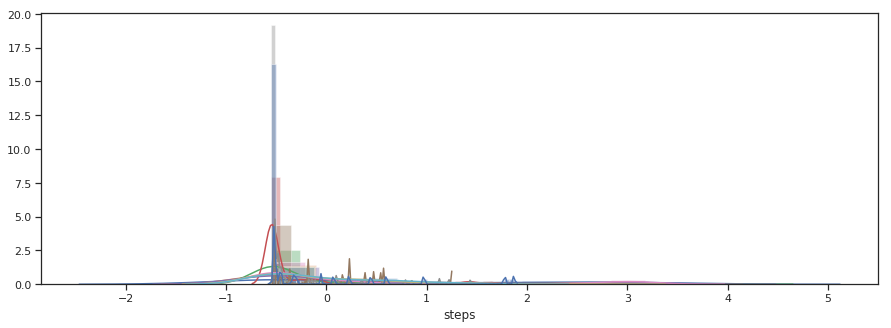

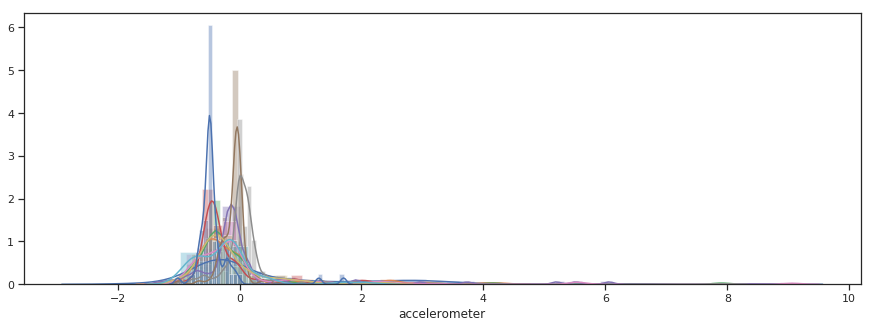

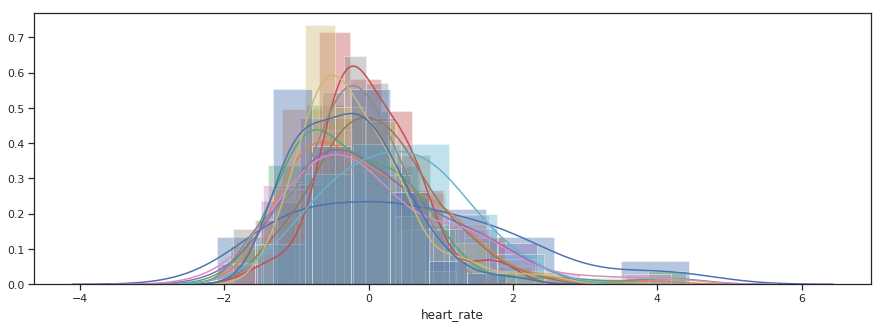

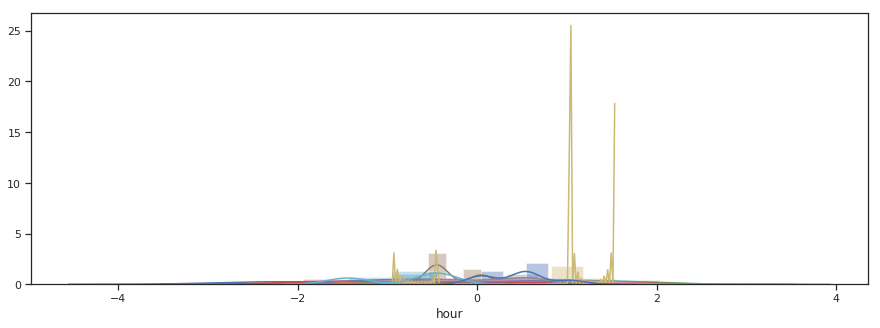

In [52]:
for variable in [
                    'audio',
                    'wifi',
                    'steps',
                    'accelerometer',
                    'heart_rate',
                    'hour'
                ]:
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set(style="ticks", color_codes=True)
    for activity_type in df_normal['activity_type'].unique():
        sns.distplot(df_normal[df_normal['activity_type'] == activity_type][variable]);

/home/agaltier/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


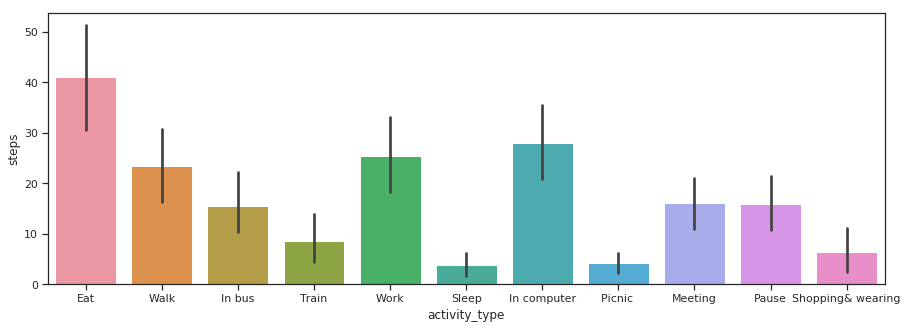

In [53]:
fig, ax = plt.subplots(figsize=(15,5))
sns.set(style="ticks", color_codes=True)
sns.barplot(x = df.activity_type, y = df.steps, estimator = mean)

### 4.  Corrélations

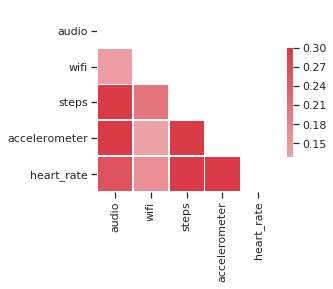

In [54]:
# Matrice de correlation
corr = X[[
            'audio',
            'wifi',
            'steps',
            'accelerometer',
            'heart_rate'
                ]].corr()

# Pour n'afficher que la partie inferieure de la matrice
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Afficher la heatmap
f, ax = plt.subplots(figsize=(4, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

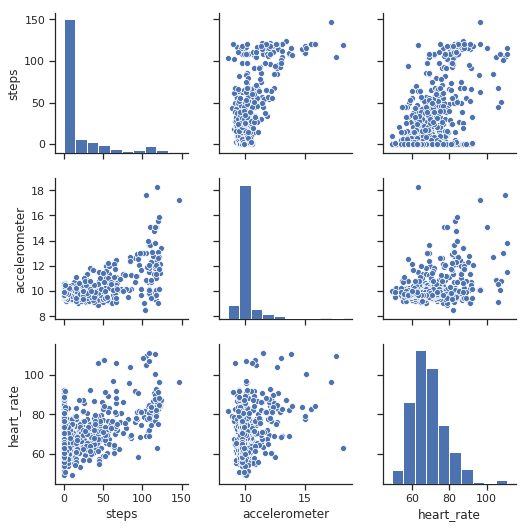

In [55]:
plot_variables = [
#     'audio',
#     'wifi',
    'steps',
    'accelerometer',
    'heart_rate'
]

sns.set(style="ticks")
sns.pairplot(df[plot_variables])

#### Test d'adequation a un loi Normale

In [56]:
from scipy.stats import shapiro

for activity_type in df.activity_type.unique():
    print(activity_type)
    for variable in [
        'audio',
        'wifi',
        'steps',
        'accelerometer',
        'heart_rate'
    ]:
        t = shapiro(list(df_normal[variable]))
        print("    " + str(variable))
        print("        Test statistic: " + str(t[0]))
        print("        P-value: " + str(t[1]))

Eat
    audio
        Test statistic: 0.8867517709732056
        P-value: 2.1492170236100432e-25
    wifi
        Test statistic: 0.5202136039733887
        P-value: 2.6624670822171524e-44
    steps
        Test statistic: 0.614295482635498
        P-value: 4.4136697730838763e-41
    accelerometer
        Test statistic: 0.5868512392044067
        P-value: 4.4463200273026446e-42
    heart_rate
        Test statistic: 0.9445138573646545
        P-value: 4.4759470864183374e-18
Walk
    audio
        Test statistic: 0.8867517709732056
        P-value: 2.1492170236100432e-25
    wifi
        Test statistic: 0.5202136039733887
        P-value: 2.6624670822171524e-44
    steps
        Test statistic: 0.614295482635498
        P-value: 4.4136697730838763e-41
    accelerometer
        Test statistic: 0.5868512392044067
        P-value: 4.4463200273026446e-42
    heart_rate
        Test statistic: 0.9445138573646545
        P-value: 4.4759470864183374e-18
In bus
    audio
        Test statistic

In [57]:
from scipy.stats import normaltest
for variable in [
    'audio',
    'wifi',
    'steps',
    'accelerometer',
    'heart_rate'
]:
    t = normaltest(list(df_normal[variable]))
    print(variable)
    print("     Test statistic: " + str(t[0]))
    print("     P-value: " + str(t[1]))

audio
     Test statistic: 165.97563387786633
     P-value: 9.095970396191051e-37
wifi
     Test statistic: 682.1666597682647
     P-value: 7.402730894881178e-149
steps
     Test statistic: 354.0213284547983
     P-value: 1.3342748131584895e-77
accelerometer
     Test statistic: 844.4828928693888
     P-value: 4.196331436985572e-184
heart_rate
     Test statistic: 173.11768216600498
     P-value: 2.5584265759623985e-38


### 4.  Analyse par Composantes Principales

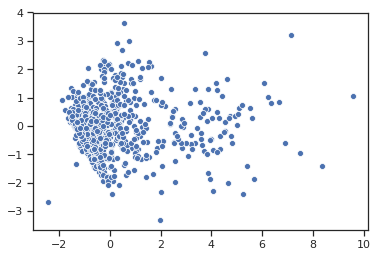

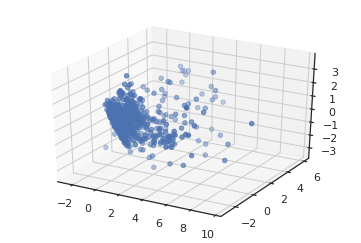

 
Explained variances:
[0.4863983692734758, 0.18745443709851914, 0.14972111381616415, 0.11295860446319014, 0.06346747534865078]
 
Sum of explained variances: 1.0
 


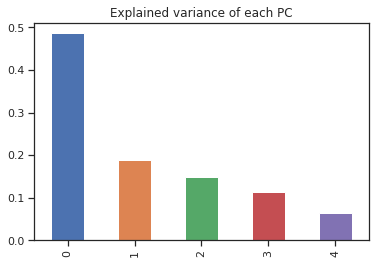

In [58]:
n_components = 5
pca = PCA(n_components = n_components)
X_pca = pca.fit_transform(X[[
                    'audio',
                    'wifi',
                    'steps',
                    'accelerometer',
                    'heart_rate'
                ]])

sns.scatterplot(X_pca[:, 0], X_pca[:, 2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2])
plt.show()

print(' ')
print('Explained variances:')
print(pca.explained_variance_ratio_.tolist())
pd.Series(pca.explained_variance_ratio_.tolist()).plot(kind="bar", title= "Explained variance of each PC")
print(' ')
print('Sum of explained variances: ' + str(sum(pca.explained_variance_ratio_.tolist())))
print(' ')

### 5. Classification

#### Sans l'ACP:

In [59]:
# activites = ['Eat']
# labels = []
# for activity_type in list(y['activity_type']):
#     if activity_type in activites:
#         labels.append(1)
#     else:
#         labels.append(0)

# labels = y['activity_type']
labels = y

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=101)

In [92]:
indexes = []
values = []
for k in range(1,20):
    accuracy = cross_val_score(KNeighborsClassifier(k), X, labels, scoring='accuracy', cv = 15)
    indexes.append(k)
    values.append(accuracy.mean())

(0.45, 0.6)

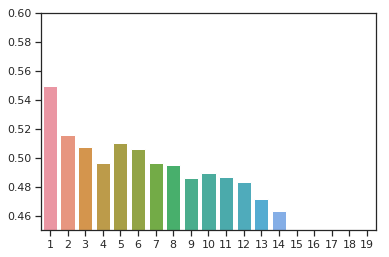

In [96]:
sns.barplot(x=indexes, y=values)
plt.ylim(0.45, 0.6)

In [97]:



names = [
    "Nearest Neighbors",
    "Decision Tree", 
    "Random Forest",
    "LDA"
]

classifiers = [
    KNeighborsClassifier(4),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis()
    ]

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))

    accuracy = cross_val_score(clf, X, labels, scoring='accuracy', cv = 15)
    print(accuracy)
    #get the mean of each fold 
    print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
    
    



Nearest Neighbors score: 0.58
[0.46268657 0.67164179 0.60606061 0.63076923 0.43076923 0.3968254
 0.5        0.47540984 0.49152542 0.37288136 0.50847458 0.53448276
 0.56140351 0.48214286 0.32142857]
Accuracy of Model with Cross Validation is: 49.64334473730162


Decision Tree score: 0.47
[0.50746269 0.59701493 0.40909091 0.41538462 0.36923077 0.3015873
 0.25806452 0.52459016 0.40677966 0.50847458 0.49152542 0.24137931
 0.24561404 0.35714286 0.30357143]
Accuracy of Model with Cross Validation is: 39.57942119640755


Random Forest score: 0.55
[0.58208955 0.46268657 0.56060606 0.43076923 0.49230769 0.3968254
 0.41935484 0.40983607 0.40677966 0.49152542 0.54237288 0.51724138
 0.40350877 0.46428571 0.25      ]
Accuracy of Model with Cross Validation is: 45.53459490548262


LDA score: 0.31
[0.31343284 0.31343284 0.36363636 0.32307692 0.21538462 0.23809524
 0.19354839 0.31147541 0.30508475 0.54237288 0.38983051 0.17241379
 0.14035088 0.10714286 0.125     ]
Accuracy of Model with Cross Valida

#### Avec l'ACP:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=21)

for name, clf in zip(names, classifiers):
    
    print("\n")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print(name + ' score: ' + str(round(score, 2)))
    
    accuracy = cross_val_score(clf, X, labels, scoring='accuracy', cv = 15)
    print(accuracy)
    #get the mean of each fold 
    print("Accuracy of Model with Cross Validation is:",accuracy.mean() * 100)
    

In [ ]:
dtree = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())